In [ ]:
# Copyright 2019 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [ ]:
# Visualization of the YAMNet audio event classification model.
# See https://github.com/tensorflow/models/tree/master/research/audioset/yamnet/
#
# This notebook can be run in Google Colab at https://colab.research.google.com
# by either downloading this ipynb and uploading it, or by looking up the
# notebook directly on GitHub in Colab's "Open notebook" dialog.

In [12]:
# Install required packages.
!pip install soundfile
!git clone https://github.com/tensorflow/models.git
%cd models/research/audioset/yamnet

# Download YAMNet data
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

!ls -l

Cloning into 'models'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41244 (delta 12), reused 21 (delta 0), pack-reused 41210
Receiving objects: 100% (41244/41244), 548.96 MiB | 34.16 MiB/s, done.
Resolving deltas: 100% (27926/27926), done.
/content/models/research/audioset/yamnet/models/research/audioset/yamnet/models/research/audioset/yamnet
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.5M  100 14.5M    0     0  27.1M      0 --:--:-- --:--:-- --:--:-- 27.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0   449k      0 --:--:-- --:--:-- --:--:--  449k
total 15280
-rw-r--r-- 1 root root     3358 Aug 11 22:54 features.py
-rw-r--

In [13]:
# Imports.
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt

import params
import yamnet as yamnet_model
import tensorflow as tf

In [15]:
# Read in the audio.
wav_file_name = 'speech_whistling2.wav'
wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0
# The graph is designed for a sampling rate of 16 kHz, but higher rates 
# should work too.
params.SAMPLE_RATE = sr
print("Sample rate =", params.SAMPLE_RATE)

Sample rate = 16000


In [16]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
params.PATCH_HOP_SECONDS = 0.1  # 10 Hz scores frame rate.
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')

In [22]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()

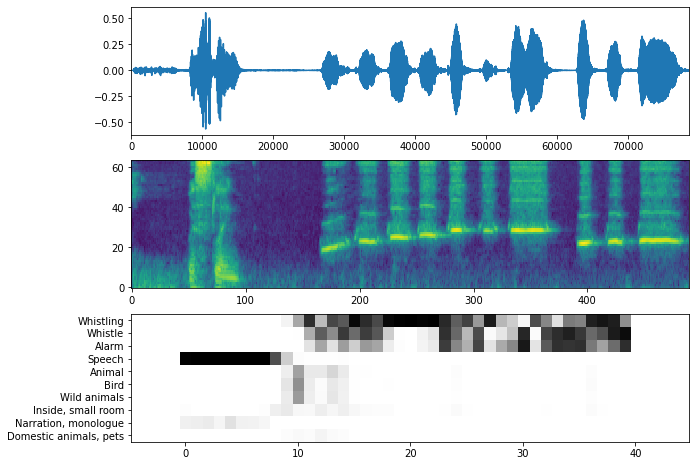

In [23]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))
